<a href="https://colab.research.google.com/github/johanjan/MOOC-HPFEM-source/blob/master/MOOC_HPFEM_Adjoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MOOC-HPFEM: Navier-Stokes fluid flow Direct FEM Simulation (DFS)



<p>Incompressible Navier-Stokes as model for low and high Reynolds number flow, such as blood flow and flight: <span class="math display">\begin{array}{rcll} 
R(\hat{u}) &;=&
\begin{cases}
  p_t u + (u\cdot \nabla) u + \nabla p - \nu \Delta u = 0\\
  \nabla \cdot u = 0
\end{cases}\\
u &;=& 0, x \in \Gamma \quad (\text{No-slip BC for low Reynolds number})\\
\hat{u} &=& (u, p), \quad r(\hat{u}, \hat{v}) = (R(\hat{u}), \hat{v}) \quad (\text{Weak residual})
\end{array}</span></p>
<dl>
<dt>Space-time cG(1)cG(1) FEM with GLS stabilization. Developed over 20+ years by Johnson, Hoffman, Jansson, etc.</dt>
<dd><p><span class="math display">\begin{aligned}
  &r(\hat{U}, \hat{v}) = (R(\hat{U}), \hat{v}) + (\delta R(\hat{U}), R(\hat{v})) = 0\\
  &\delta = h, \, \forall \hat{v} \in \hat{V}_h, \, \hat{U} \in \hat{V}_h\end{aligned}</span></p>
</dd>

### FEniCS DFS formulation to run and modify yourself

In [0]:
#@title
# Setup system environment and define utility functions and variables
from google.colab import files
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
    !mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
    !sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
    !mv temp /etc/apt/sources.list
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics    
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display, update_display; import time; import dolfin.common.plotting as fenicsplot 
import time
from ufl import replace

def plot_compact(u, t, stepcounter, QQ, pl, ax, label = "Velocity", clear = True): # Compact plot utility function
  if stepcounter == 0:
    pl, ax = plt.subplots(); display(pl);
    if clear:
      clear_output(); # Plotting setup
  if stepcounter % 5 == 0:
    uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("%s at t=%f" % (label, t)) # Plot norm of velocity
    if t == 0.: plt.axis(G); plt.colorbar(pp, shrink=0.5); 
    plt.subplot(1, 2, 2);
    if t == 0.: plot(Q.mesh()); plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)

def plot_compact_static(u, QQ, label = "Velocity"): # Compact plot utility function
  pl, ax = plt.subplots();
  uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
  plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("%s" % (label)) # Plot norm of velocity
  plt.axis(G); plt.colorbar(pp, shrink=0.5); 
  plt.subplot(1, 2, 2);
  plot(Q.mesh()); plt.title("Mesh") # Plot mesh
  plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)

XMIN = 0.; XMAX = 2.5; YMIN = 0; YMAX = 0.41; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5; mresolution=10 # Geometry and mesh
ghole = [0.15, 0.25, 0.15, 0.25];
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Rectangle(Point(ghole[0],ghole[2]),Point(ghole[1],ghole[3]) ), mresolution)

stepcounter = 0; pl = None; ax = None

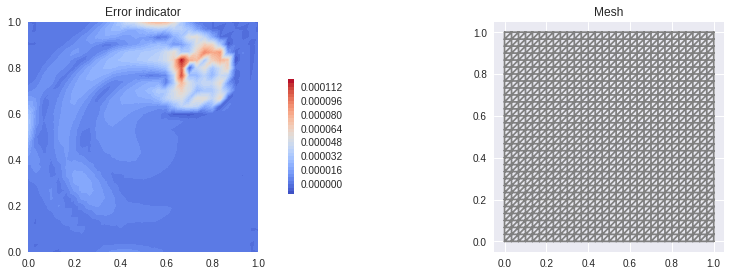

(<matplotlib.figure.Figure at 0x7f75bca6d4a8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f75bca4ee48>)

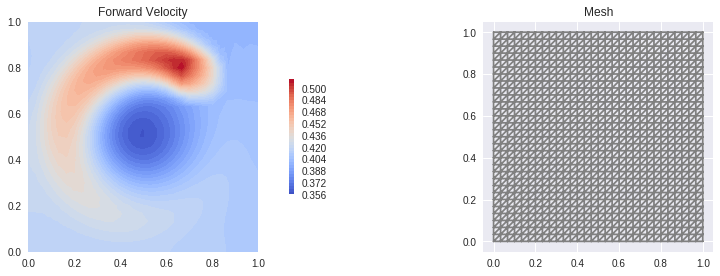

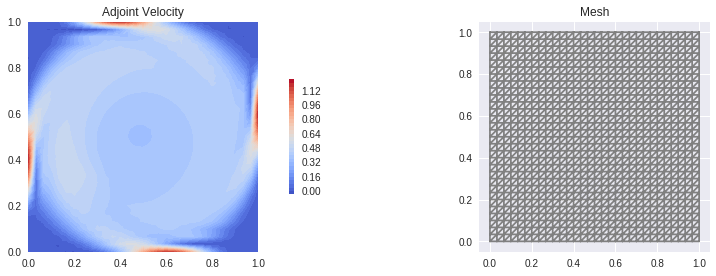

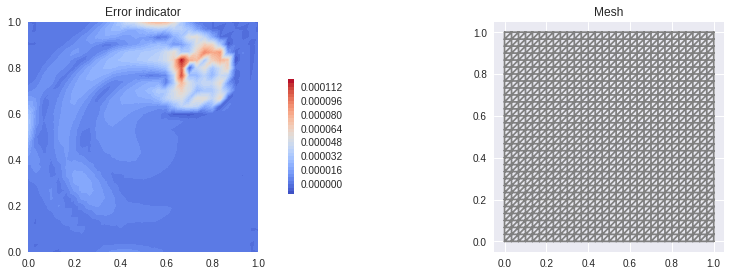

In [2]:
# Copyright (c) 2017-2018 Johan Jansson, Cem Degirmenci
#Define domain and mesh
XMIN = 0.; XMAX = 1; YMIN = 0; YMAX = 1.; 
G = [XMIN, XMAX, YMIN, YMAX]; 
mesh = UnitSquareMesh(30,30)

# Declare FE spaces                                                                                                              
Q = FunctionSpace(mesh, "CG", 1)
V = VectorFunctionSpace(mesh, "CG", 1)
h = CellDiameter(mesh); # FEM functions

u = Function(Q);
phi = Function(Q);
u_ =TrialFunction(Q);
v = TestFunction(Q);

Z = FunctionSpace(mesh, "DG", 0)
z = TestFunction(Z)
  
alpha = 0.1
epsilon = 0.01

f= Expression("((x[0] - 0.75)*(x[0] - 0.75) + (x[1] - 0.75)*(x[1] - 0.75)) < 0.1*0.1 ? 1 : 0", element = Q.ufl_element())
psi= Expression("((x[0] - 0.25)*(x[0] - 0.25) + (x[1] - 0.25)*(x[1] - 0.25)) < 0.1*0.1 ? 1 : 0", element = Q.ufl_element())
beta = Expression(("-5*(x[1] - 0.5)", "5*(x[0] - 0.5)"), element = V.ufl_element())

# Primal problem
a = (epsilon*inner(grad(u_), grad(v)) + inner(beta, grad(u_))*v + alpha*u_*v)*dx
L = (f*v)*dx
solve(a==L, u)
plot_compact_static(u, Q, "Forward Velocity") # Plot all quantities (see implementation above)

# Adjoint problem
a_adjoint = adjoint(a)
L_adjoint = (psi*v)*dx
solve(a_adjoint==L_adjoint, phi)
plot_compact_static(phi, Q, "Adjoint Velocity") # Plot all quantities (see implementation above)

# Error indicator
r = action(a, u) - L # Construct Forward residual
Lei = replace(r, {v:phi*z}); # Construct error indicators
ei = Function(Z)
ei.vector()[:] = abs(assemble(Lei).get_local())
plot_compact_static(ei, Q, "Error indicator") # Plot all quantities (see implementation above)
